# Classification et explication des données

Nous allons maintenant utiliser les données pour faire de la classification et de l'explication. Nous allons utiliser les données de la base de données Image Net qui contient des images de différents animaux.

Pour réaliser cette tâhce, nous allons utiliser une ensemble d'image issue de la base de données Image Net. Nous allons utiliser les images de 6 classes différentes. Pour chaque classe, nous avons 99% images d'entrainement et 1% images de test. Les classes sont les suivantes :

- n02114367 (loup)
- n01484850 (requin)
- n01614925 (aigle)
- n02133161 (ours)
- n01537544 (passerin indigo)
- n01443537 (poisson rouge)

Nous allons utiliser les images d'entrainement pour entrainer un modèle de classification et les images de test pour évaluer la performance du modèle. Nous allons ensuite utiliser les images de test pour expliquer les prédictions du modèle.

Nous allons diviser notre travail différentes parties :

1) Récupérer les données sur Kaggle et sélectionner les images des classes qui nous intéressent (https://www.kaggle.com/c/imagenet-object-localization-challenge)
2) Traiter les données, cela implique de les diviser en classe égale et de les redimensionner, pour ce faire, nous pourrons utiliser des bibliothèques comme OpenCV ou Pillow
3) Diviser les données en données d'entrainement et données de test
4) Le choix du modèle de classification : nous utiliserons des modèles couramment utilisés pour la classification d'images incluent les réseaux de neurones convolutionnels (CNN), qui ont obtenu de bons résultats dans de nombreux domaines.
5) Entrainer un modèle de classification, pour ce faire, nous pourrons utiliser des bibliothèques comme Keras ou PyTorch ou TensorFlow
6) Évaluer la performance du modèle sur les données de test, et obtenir l'accuarcy du modèle
7) Utiliser les images de test pour expliquer les prédictions du modèle, pour ce faire, nous pourrons utiliser des bibliothèques comme LIME ou SHAP


In [34]:
# Importer les bibliothèques nécessaires
import os
import shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [35]:
# Définir les classes qui nous intéressent
classes = ['n02114367', 'n01484850', 'n01614925', 'n02133161', 'n01537544', 'n01443537']
classes_names = {'n02114367': 'loup', 'n01484850': 'requin', 'n01614925': 'aigle', 'n02133161': 'ours', 'n01537544': 'passerin indigo', 'n01443537': 'poisson rouge'}

# Définir le chemin vers les données
data_path = './ILSVRC/Data/CLS-LOC/train'

In [36]:
# Créer un dossier pour stocker les images des classes qui nous intéressent
os.makedirs('./data', exist_ok=True)
for c in classes:
    os.makedirs('./data/' + c, exist_ok=True)

In [37]:
from PIL import UnidentifiedImageError

# Copier 300 images des classes qui nous intéressent dans le dossier que nous venons de créer, en les formatant à la même taille

taille_data = 1200

for c in classes:
    files = os.listdir(os.path.join(data_path, c))
    for f in files[:taille_data]:
        # Vérifier si le fichier est un fichier d'image valide
        try:
            im = Image.open(os.path.join(data_path, c, f))
            im.verify()
            shutil.copy(os.path.join(data_path, c, f), os.path.join('./data', c, f))
            im = Image.open(os.path.join('./data', c, f))
            im = im.resize((224, 224))
            im.save(os.path.join('./data', c, f))
        except (IOError, SyntaxError, UnidentifiedImageError) as e:
            # Le fichier n'est pas une image valide, ignorer
            pass

In [38]:
# Diviser les données en données d'entrainement et données de test
# Nous allons utiliser 99% des données pour l'entrainement et 1% pour le test
# Nous allons stocker les données d'entrainement dans un dossier train et les données de test dans un dossier test

# Créer les dossiers train et test
for c in classes:
    os.makedirs('./data/train/' + c, exist_ok=True)
    os.makedirs('./data/test/' + c, exist_ok=True)

pourcentage_train = 0.90

os.makedirs('./data/train', exist_ok=True)
os.makedirs('./data/test', exist_ok=True)

for c in classes:
    files = os.listdir(os.path.join('./data', c))
    for f in files[:round(pourcentage_train * len(files))-1]:
        shutil.copy(os.path.join('./data', c, f), os.path.join('./data/train', c, f))
    for f in files[round(pourcentage_train * len(files))-1:]:
        shutil.copy(os.path.join('./data', c, f), os.path.join('./data/test', c, f))

In [39]:
# Importer les bibliothèques nécessaires
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Définir la taille du batch
batch_size = 4

# Définir les transformations à appliquer aux images
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# Charger les données d'entrainement
trainset = torchvision.datasets.ImageFolder(root='./data/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Charger les données de test

testset = torchvision.datasets.ImageFolder(root='./data/test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Définir les classes
classes = ('n01443537', 'n01484850', 'n01537544', 'n01614925', 'n02114367', 'n02133161')

In [40]:
# Définir le modèle
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Définir les couches de convolution
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Définir les couches linéaires
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)

    def forward(self, x):
        # Appliquer les couches de convolution
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))

        # Appliquer les couches linéaires
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        # Appliquer la fonction softmax
        x = F.softmax(x, dim=1)
        return x

# Instancier le modèle
net = Net()

# Définir la fonction de coût

criterion = nn.CrossEntropyLoss()

# Définir l'optimiseur
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [41]:
# Entrainer le modèle
nb_epochs = 10

for epoch in range(nb_epochs):  # boucle sur le jeu de données plusieurs fois

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # obtenir les entrées, data est une liste de [entrées, étiquettes]
        inputs, labels = data

        # Remettre à zéro les gradients
        optimizer.zero_grad()

        # Faire une propagation avant et obtenir les sorties
        outputs = net(inputs)

        # Calculer la perte
        loss = criterion(outputs, labels)

        # Faire une propagation arrière et optimiser
        loss.backward()
        optimizer.step()

        # Afficher les statistiques
        running_loss += loss.item()
        if i % 100 == 99:    # afficher toutes les 100 mini-batchs
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Entrainement terminé')

[1,   100] loss: 1.791
[1,   200] loss: 1.790
[1,   300] loss: 1.787
[1,   400] loss: 1.780
[1,   500] loss: 1.763
[1,   600] loss: 1.721
[1,   700] loss: 1.618
[1,   800] loss: 1.538
[1,   900] loss: 1.572
[1,  1000] loss: 1.525
[1,  1100] loss: 1.510
[1,  1200] loss: 1.504
[1,  1300] loss: 1.449
[1,  1400] loss: 1.484
[1,  1500] loss: 1.417
[1,  1600] loss: 1.472
[2,   100] loss: 1.461
[2,   200] loss: 1.429
[2,   300] loss: 1.431
[2,   400] loss: 1.419
[2,   500] loss: 1.372
[2,   600] loss: 1.386
[2,   700] loss: 1.361
[2,   800] loss: 1.455
[2,   900] loss: 1.366
[2,  1000] loss: 1.389
[2,  1100] loss: 1.381
[2,  1200] loss: 1.404
[2,  1300] loss: 1.412
[2,  1400] loss: 1.392
[2,  1500] loss: 1.373
[2,  1600] loss: 1.385
[3,   100] loss: 1.328
[3,   200] loss: 1.357
[3,   300] loss: 1.376
[3,   400] loss: 1.376
[3,   500] loss: 1.348
[3,   600] loss: 1.355
[3,   700] loss: 1.377
[3,   800] loss: 1.369
[3,   900] loss: 1.338
[3,  1000] loss: 1.302
[3,  1100] loss: 1.315
[3,  1200] 

In [42]:
# Tester le modèle
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculer les sorties
        outputs = net(images)
        # Obtenir la classe prédite
        _, predicted = torch.max(outputs.data, 1)
        # Calculer le nombre total d'images
        total += labels.size(0)
        # Calculer le nombre d'images correctement prédites
        correct += (predicted == labels).sum().item()

print('Précision du modèle sur les %d images de test: %d %%' % (taille_data,
    100 * correct / total))

Précision du modèle sur les 1200 images de test: 69 %


Classe prédite:  n01484850
Nom de la classe: requin


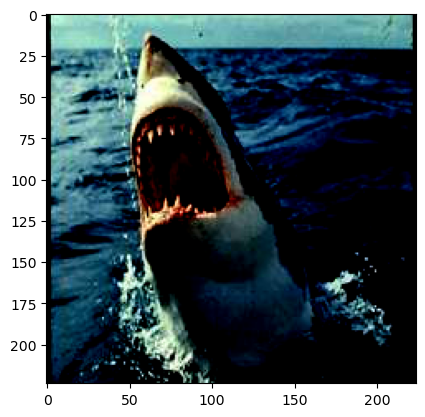

In [49]:
# Essayer le modèle sur une image
import random

dossier = './data/test/n01484850'  # Remplacez par le chemin vers le dossier contenant les fichiers
fichiers = os.listdir(dossier)  # Liste de tous les fichiers dans le dossier
fichier_aleatoire = random.choice(fichiers)  # Choix d'un fichier au hasard
chemin_fichier = os.path.join(dossier, fichier_aleatoire)  # Chemin complet du fichier choisi


# Charger une image
im = Image.open(chemin_fichier)
# Appliquer les transformations
im = transform(im)
# Ajouter une dimension
im = im.unsqueeze(0)
# Obtenir les sorties
outputs = net(im)
# Obtenir la classe prédite
_, predicted = torch.max(outputs.data, 1)
print('Classe prédite: ', classes[predicted.item()])
print('Nom de la classe:', classes_names[classes[predicted.item()]])
# Afficher l'image
im_normalized = im.clamp(0, 1)
plt.imshow(np.transpose(im_normalized.squeeze().numpy(), (1, 2, 0)))

In [44]:
# Sauvegarder le modèle
PATH = './model.pth'
torch.save(net.state_dict(), PATH)

In [45]:
# Charger le modèle

#net = Net()
#net.load_state_dict(torch.load(PATH))